In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training import train_state
from functools import partial
# from relative_fitness_mechanisms.selective_pressure_prediction import (create_lagged_features, 
#                                                                        process_inputs_all, 
#                                                                        withhold_test_locations_and_split, 
#                                                                        SelectivePressureData
#                                                                        create_training_batches,
#                                                                       train_step, 
#                                                                       loss_fn)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

In [2]:
## Prepping data

import sys
sys.path.append( '../relative_fitness_mechanisms/')
import plot_utils
from selective_pressure_prediction import (create_lagged_features, 
                                           process_inputs_all, 
                                            withhold_test_locations_and_split, 
                                            SelectivePressureData,
                                            create_training_batches,
                                            train_step, 
                                            loss_fn)

from ml_utils import TrainerModule

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t")
selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases.tsv", sep="\t")

selective_pressure_df["date"] = pd.to_datetime(selective_pressure_df["date"])

In [4]:
selective_pressure_df = selective_pressure_df.dropna()

In [5]:
input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]

# Create lagged features by group
for loc, group in selective_pressure_df.groupby("location"):
    input_dfs[loc] = create_lagged_features(
        group[keep_features + keep_targets], 
        ["selective_pressure"], 
        28)

In [6]:
dates_vec, locations_vec, X, y = process_inputs_all(input_dfs, target=TARGET)

In [7]:
WITHHELD_LOCATIONS = ["England"]
X_train, y_train, X_test, y_test = withhold_test_locations_and_split(X, y, locations_vec, WITHHELD_LOCATIONS)

In [8]:
from ml_utils import create_data_loaders

    
train_set = SelectivePressureData(X_train.values, y_train.values)
val_set = SelectivePressureData(X_test.values, y_test.values)
train_loader, val_loader = create_data_loaders(train_set, val_set,
                                                            train=[True, False],
                                                            batch_size=64,
                                                            num_workers=1)

In [9]:
# Defining model
from flax import linen as nn

class PositionalEncoding(nn.Module):
    max_len: int
    d_model: int

    @nn.compact
    def __call__(self, x):
        pe = self.positional_encoding(self.max_len, self.d_model)
        pe = pe[:x.shape[1], :]  # Adjust the length to match the input sequence length
        pe = jnp.expand_dims(pe, axis=0)  # Add batch dimension
        x = x + pe  # Broadcasting positional encoding to the batch size
        return x
    
    def positional_encoding(self, max_len, d_model):
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return pe
    
class FeedForward(nn.Module):
    d_model: int
    d_ff: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_model)(x)
        return x
    
class BlockLayer(nn.Module):
    d_model: int
    num_heads: int
    d_ff: int

    @nn.compact
    def __call__(self, x):
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads, qkv_features=self.d_model, use_bias=True
        )(x)
        x = nn.LayerNorm()(x + attn_output)

        ff_output = FeedForward(d_model=self.d_model, d_ff=self.d_ff)(x)
        x =  nn.LayerNorm()(x + ff_output)
        return x
    
class SimpleTransformer(nn.Module):
    num_heads: int
    d_model: int  # Size of the attention representations
    d_ff: int  # Size of feedforward
    output_dim: int  # Dimensionality of the regression output

    @nn.compact
    def __call__(self, x, **kwargs):
        x = nn.Dense(self.d_model)(x)
        x = nn.relu(x)
        
        x = jnp.expand_dims(x, axis=-1)
        x = PositionalEncoding(max_len=x.shape[1], d_model=self.d_model)(x)
        
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)

        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)        
        x = nn.Dense(self.output_dim)(x)
        x = jnp.squeeze(x, axis=-1)
        x = jnp.mean(x, axis=-1)
        return x
    
# Define loss function
combined_loss_fn = partial(loss_fn, alpha=1e-4)

In [10]:
class TransformerTrainer(TrainerModule):

    def __init__(self,
                 num_heads, 
                 d_model, 
                 d_ff, 
                 output_dim,
                 **kwargs):
        super().__init__(
            model_class=SimpleTransformer, 
            model_hparams={
                'num_heads': num_heads,
                'd_model': d_model,
                'd_ff': d_ff,
                'output_dim': output_dim
            }, **kwargs)

    def create_functions(self):

        def train_step(state, batch):
            """
            Perform a single training step.
            
            Args:
              state: The current training state.
              batch: A batch of training data.
              
            Returns:
              Updated training state and training metrics.
            """
            x, y = batch
            grad_fn = jax.value_and_grad(lambda p: combined_loss_fn({'params': p}, state, x, y))
            loss, grads = grad_fn(state.params)
            state = state.apply_gradients(grads=grads)

            metrics = {
                'loss': loss,
            }
            return state, metrics

        def eval_step(state, batch):
            """
            Perform a single evaluation step.
            
            Args:
              state: The current training state.
              batch: A batch of evaluation data.
              
            Returns:
              Evaluation metrics.
            """
            x, y = batch
            loss = combined_loss_fn({'params': state.params}, state, x, y)
            
            metrics = {
                'loss': loss,
            }

            return metrics

        return train_step, eval_step

In [11]:
import os

trainer = TransformerTrainer(
    num_heads=4, 
    d_model=32, 
    d_ff=32, 
    output_dim=1,
    optimizer_hparams={'lr': 4e-4}, 
    exmp_input=next(iter(train_loader))[0:1],
    logger_params={'base_log_dir': os.path.abspath("./saved_models/")})


                           SimpleTransformer Summary                            
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ SimpleTransf… │ -             │ float32[64]  │               │
│               │               │ float32[64,2… │              │               │
│               │               │ - train: True │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Dense_0       │ Dense         │ float32[64,2… │ float32[64,… │ bias:         │
│               │               │               │              │ float32[32]   │
│               │               │               │              │ kernel:       │
│               │               │               │              │ float32[29,3… │
│               │          

In [12]:
metrics = trainer.train_model(train_loader,
                              val_loader,
                              test_loader=None,
                              num_epochs=50);
metrics

Training:  98%|██████████████████████████████████████████████████████████████████████████████████████  | 89/91 [00:01<00:00, 50.66it/s]


Training:  80%|██████████████████████████████████████████████████████████████████████▌                 | 73/91 [00:01<00:00, 49.37it/s]


Training:  55%|████████████████████████████████████████████████▎                                       | 50/91 [00:01<00:00, 47.15it/s]


Training:  46%|████████████████████████████████████████▌                                               | 42/91 [00:00<00:01, 48.55it/s]


Training:  40%|██████████████████████████████████▊                                                     | 36/91 [00:00<00:01, 48.74it/s]


Training:  23%|████████████████████▎                                                                   | 21/91 [00:00<00:01, 49.11it/s]


Training:  18%|███████████████▍                                                                        | 16/91 [00:00<00:01, 49.67it/s]


Training:  24%|█████████████████████▎                                                                  | 22/91 [00:00<00:01, 49.76it/s]


Training:  25%|██████████████████████▏                                                                 | 23/91 [00:00<00:01, 50.22it/s]


Training:  29%|█████████████████████████▏                                                              | 26/91 [00:00<00:01, 49.67it/s]


Training:  32%|████████████████████████████                                                            | 29/91 [00:00<00:01, 50.60it/s]


Training:  32%|████████████████████████████                                                            | 29/91 [00:00<00:01, 50.21it/s]


Training:  22%|███████████████████▎                                                                    | 20/91 [00:00<00:01, 48.98it/s]


Training:  96%|████████████████████████████████████████████████████████████████████████████████████▏   | 87/91 [00:02<00:00, 41.68it/s]


Training:  73%|███████████████████████████████████████████████████████████████▊                        | 66/91 [00:01<00:00, 48.81it/s]


Training:  44%|██████████████████████████████████████▋                                                 | 40/91 [00:00<00:01, 46.34it/s]


Training:  16%|██████████████▌                                                                         | 15/91 [00:00<00:01, 48.86it/s]


Epochs: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:04<00:00,  4.90s/it]


{'val/loss': 0.030865227803587914,
 'train/loss': 0.03358151763677597,
 'epoch_time': 1.8158459663391113}

In [13]:
model_bd = trainer.bind_model()

In [14]:
# Subset locations
locations_subset = ["California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

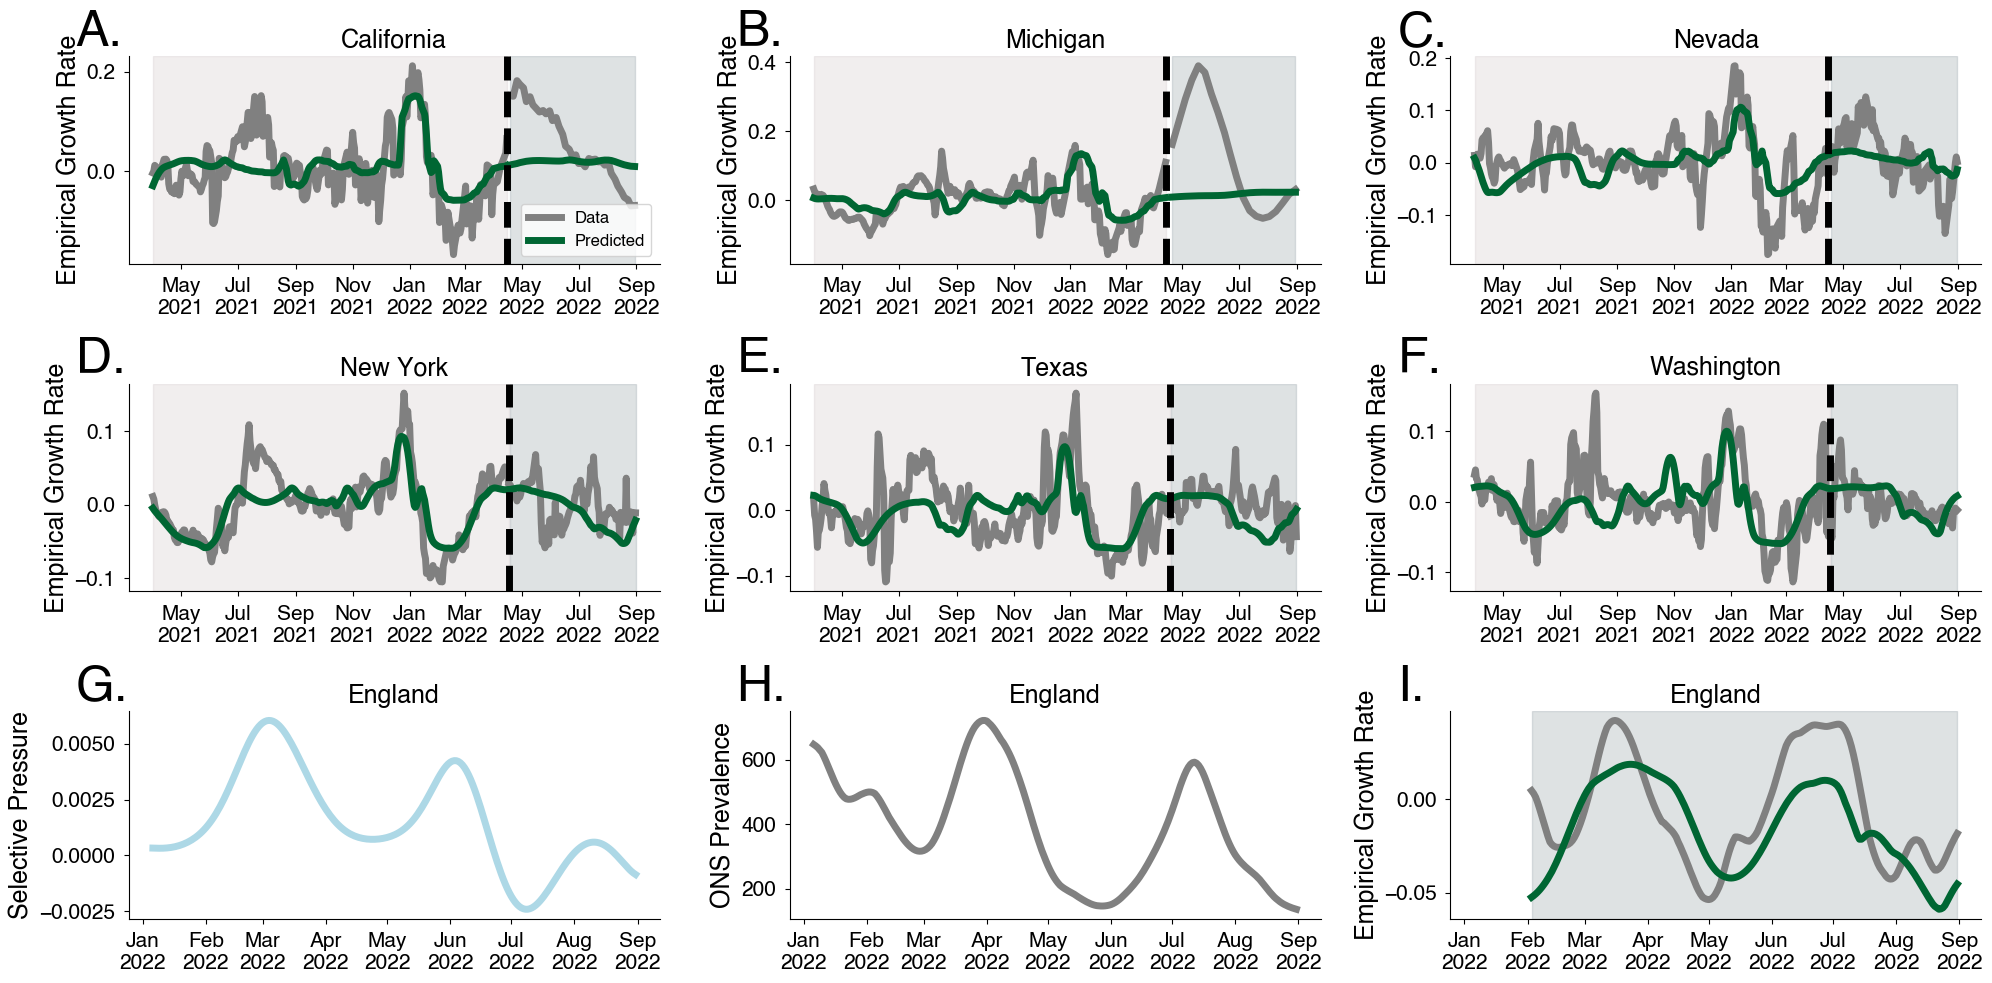

In [15]:
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 + 1)

TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

axes = []

data = {loc: df for loc, df in selective_pressure_df.groupby("location")}

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X_train.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data point
    ax.plot(dates_vec[X_train.index][loc_idx_train], y_train[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    pred_train = model_bd(X_train[loc_idx_train].values)
    pred_test = model_bd(X_test[loc_idx_test].values)
    
    ax.plot(dates_vec[X_train.index][loc_idx_train], pred_train, color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], pred_test, color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X_train.index][loc_idx_train].min(), dates_vec[X_train.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 0], sharex=None if _l==0 else ax)
    ax.plot(data[loc]["date"], data[loc]["selective_pressure"], color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 1], sharex = ax)    
    ax.plot(data[loc]["date"], data[loc]["smooth_cases"], color="grey")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X_train.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X_train.index][loc_idx_train], y_train[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    pred_train = model_bd(X_train[loc_idx_train].values)
    pred_test = model_bd(X_test[loc_idx_test].values)

    ax.plot(dates_vec[X_train.index][loc_idx_train], pred_train, color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], pred_test, color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X_train.index][loc_idx_train].min(), dates_vec[X_train.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
fig.tight_layout()